In [82]:
# Import required libraries and load environment variables
from langchain_cohere import ChatCohere
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List, Literal
from pydantic import Field, BaseModel
from dotenv import load_dotenv
import os

load_dotenv()

True

In [83]:
# Initialize the Cohere LLM
llm = ChatCohere(model="command-a-03-2025")

In [84]:
# Schema for diagnosing negative reviews
class Diagnosis_Schema(BaseModel):
    issue_type: Literal["Bug", "Feature", "Performance", "Security", "Usability", "Other"]
    tone : Literal["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised", "Other"]
    Cause: str

In [85]:
# Schema for sentiment analysis output
class sentiment_schema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")


In [86]:
# LLM with structured output for sentiment
structured_llm = llm.with_structured_output(sentiment_schema)

In [87]:
# LLM with structured output for diagnosis
structured_llm_Diagnosis = llm.with_structured_output(Diagnosis_Schema)

In [88]:
# Test the sentiment LLM
# Example: Should return positive
txt = "identify sentiment of this review - The book is a great read, highly recommended!"
structured_llm.invoke(txt)

sentiment_schema(sentiment='positive')

In [89]:
# State definition for the review workflow
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [90]:
# Analyze the sentiment of the review
def analyze_sentiment(state: ReviewState):
    prompt = f"Identify sentiment of this review - \n {state['review']}"
    sentiment = structured_llm.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [91]:
# Decide next step based on sentiment
def check_sentiment(state: ReviewState):
    if state["sentiment"] == "positive":
        return "Positive_Response"
    else:
        return "diagnose_sentiment"

In [92]:
# Generate a positive response for positive reviews
def Positive_Response(state: ReviewState):
    prompt = f"Based on the review - {state['review']}, give a heart warming positive response and also kindly ask them to rate the services provided by the company."
    response = llm.invoke(prompt).content
    return {"response": response}

In [93]:
# Diagnose the negative review for further action
def diagnose_sentiment(state: ReviewState):
    prompt = f"Based on the review - {state['review']}, diagnose this negative review. Return its issue type, tone and its cause."
    diagnosis = structured_llm_Diagnosis.invoke(prompt)
    # Ensure a dictionary is returned to update the state
    return {"diagnosis": diagnosis.model_dump()}

In [94]:
# Generate an empathetic response for negative reviews
def Negative_response(state: ReviewState):
    diagnosis = state["diagnosis"]
    prompt = f"""
    you are a helpful assistant
    the user had a {diagnosis["issue_type"]} issue with {diagnosis["tone"]} tone.
    {diagnosis["Cause"]}. write a empathetic, helpful response to resolve the issue.
    """
    response = llm.invoke(prompt).content
    return {"response": response}


In [95]:
# Build the workflow graph
graph = StateGraph(ReviewState)

graph.add_node("analyze_sentiment", analyze_sentiment)
graph.add_node("Positive_Response", Positive_Response)
graph.add_node("diagnose_sentiment", diagnose_sentiment)
graph.add_node("Negative_response", Negative_response)

graph.add_edge(START, "analyze_sentiment")
# Conditional edge based on sentiment
graph.add_conditional_edges("analyze_sentiment", check_sentiment, {"Positive_Response": "Positive_Response", "diagnose_sentiment": "diagnose_sentiment"})

graph.add_edge("Positive_Response", END)
graph.add_edge("diagnose_sentiment", "Negative_response")
graph.add_edge("Negative_response", END)

workflow = graph.compile()

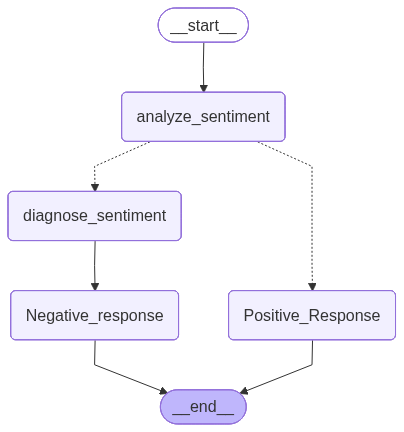

In [98]:
# Compile the workflow graph
graph.compile()

In [99]:
# Example initial state for workflow execution
initial_state = {
    "review": "The book is a awful",
    "sentiment": None,
    "diagnosis": None,
    "response": None
}

# Run the workflow (should use 'graph' not 'workflow')
workflow.invoke(initial_state)

{'review': 'The book is a awful',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Usability',
  'tone': 'Angry',
  'Cause': "The book is described as 'awful', indicating a strong dissatisfaction with its content, structure, or overall quality."},
 'response': "I'm really sorry to hear that you had such a frustrating experience with the book. It’s completely understandable to feel disappointed when something doesn’t meet your expectations, especially when it comes to something as personal as reading. I can imagine how upsetting it must be to invest time in a book only to find it doesn’t resonate with you at all.  \n\nIt sounds like the content, structure, or overall quality didn’t align with what you were hoping for, and that’s totally valid. Everyone has different tastes and preferences, and what works for one person might not work for another. I appreciate you sharing your feelings about it—it’s important to acknowledge when something isn’t a good fit.  \n\nIf you’d like, I’d 